In [1]:
import numpy as np
import polytope as pc
from itertools import combinations

import matplotlib.pyplot as plt
from matplotlib import patches

import sys
sys.path.append('../')

from best.abstraction import LTIAbstraction
from best.ltl import solve_ltl_cosafe

from Models.Linear import LTI

# Define the linear time invariant system
#A = np.array([[0,-0.8572],[0.1,0.5]])
dim = 2
A = np.eye(2) #np.array([[.9,-0.32],[0.1,0.9]])
B = np.eye(dim)  #array([[1], [0.1]])
W = np.array([[0,0],[0,0.4]]) #2*Tr.dot(np.eye(dim)).dot(Tr)  # noise on transitions
 
# Accuracy
C = np.array([[1, 0],[0,1]])  # defines metric for error (||y_finite-y||< epsilon with y= cx   )

sys_lti = LTI(A, B, C, None, W=W)  # LTI system with   D = None
sys_lti.setU(pc.box2poly(np.kron(np.ones((sys_lti.m, 1)), np.array([[-1, 1]])))) # continuous set of inputs
sys_lti.setX(pc.box2poly(np.kron(np.ones((sys_lti.dim, 1)), np.array([[-10, 10]])))) # X space


In [2]:
# Define regions of interest for the labeling
regions = dict()
regions['target'] = pc.box2poly(np.kron(np.ones((2, 1)), np.array([[5, 10]])))
# add avoid
regions['avoid'] = pc.box2poly(np.array([[-5, 3],[-10, 5]]))

In [3]:
## step 1: tune gridding ratio (find optimal horizontal d_1, and vertical d_2)
# currently only available for 2D
# d_opt, d_vals, eps_values = tune_dratio(sys_n)

d_opt = np.array([[ 0.69294],
                  [ 0.721  ]])

# d = np.array([[1.5], [1.5]])
d = d_opt

Warning no inputspace given
Warning no state space given
status: optimal
optimal epsilon 1.00000639831
optimal M [[ 1.  0.]
 [ 0.  1.]]
Optimal K [[ 0. -1.]
 [-1.  0.]]
('check norm of rows', matrix([[ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 1.,  0.]]))
('check norm of rows', matrix([[ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 1.,  0.]]))
MDP: 16 inputs "u_d" --> 871 outputs "(s, x_d)"


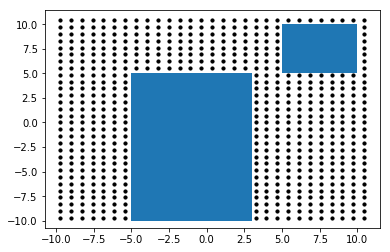

In [4]:
# mdp_grid = sys_n.abstract_io(d, un=4, verbose=False)  # do the gridding
# mdp_grid.map_dfa_inputs(dict_input2prop, regions)
abstr = LTIAbstraction(sys_lti, d, un=4)
abstr.set_regions(regions)

in_regions, nin_regions = abstr.map_dfa_inputs()

fig = plt.figure()
ax0 = fig.add_subplot(111)
abstr.plot(ax0)

# plot regions
for poly in regions.itervalues():
    V = pc.extreme(poly)
    ax0.add_patch(patches.Polygon(V))

print abstr.mdp

### Set up LTL problem

In [5]:
from best import subsets

formula = '( ( ! avoid U target ) & ( F avoid ) )'

# mapping (s, xd) -> 2^2^{target, avoid}
def connection(s_x):
    s = s_x[0]
    if s == abstr.mdp.N-1:
        return set([ (), ])
    know_in = []
    know_out = []
    for reg in regions.keys():
        if in_regions[reg][s] == 0:
            know_out.append(reg)
        if nin_regions[reg][s] == 0:
            know_in.append(reg)
    uncertain = list(set(regions.keys()) - set(know_in) - set(know_out))
            
    return set([ tuple(know_in + unc) for unc in subsets(uncertain)])

### Solve recursion

In [6]:
pol = solve_ltl_cosafe(abstr.mdp, formula, connection, algorithm='petter')

iteration 0, time 7.86781311035e-06
iteration 1, time 0.0189299583435
iteration 2, time 0.0374648571014
iteration 3, time 0.0545229911804
iteration 4, time 0.0724990367889
iteration 5, time 0.0899128913879
iteration 6, time 0.107450008392
iteration 7, time 0.125205993652
iteration 8, time 0.142649888992
iteration 9, time 0.160337924957
iteration 10, time 0.177996873856
iteration 11, time 0.195785999298
iteration 12, time 0.21405005455
iteration 13, time 0.233274936676
iteration 14, time 0.251986980438
iteration 15, time 0.269716978073
iteration 16, time 0.286097049713
iteration 17, time 0.303464889526
iteration 18, time 0.320581912994
iteration 19, time 0.337599992752
iteration 20, time 0.353905916214
iteration 21, time 0.370441913605
iteration 22, time 0.387275934219
iteration 23, time 0.40417098999
iteration 24, time 0.422499895096
iteration 25, time 0.444359064102
iteration 26, time 0.465185880661
iteration 27, time 0.482390880585
iteration 28, time 0.499261856079
iteration 29, time

### Define policy and plot

(-15, 15)

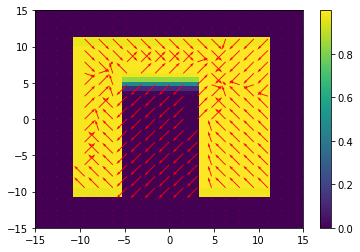

In [7]:
# define refined policy around LTL policy
def my_policy(x):
    x = np.array(x).reshape((2,1))
    
    # update internal state
    pol.report_aps(abstr.aps(x))
    
    # get abstract state
    s_abstract = abstr.closest_abstract(x)
    
    # get abstract input and refine
    u_ab, _ = pol.get_input(s_abstract)
    u_refined = abstr.refine_input(u_ab, s_abstract, x)
    
    return u_refined

# extract value at a concrete state
def my_value(x):
    s_abstract = abstr.closest_abstract(x)
    _, val = pol.get_input(s_abstract)
    return val

def my_policy_init(x):
    u = my_policy(x)
    pol.reset()
    return u

fig = plt.figure()
x_edge = np.linspace(-15,15,50)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,50)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)
xi = xi.flatten()
yi = yi.flatten()

values = np.array([my_value((x,y)) for (x,y) in zip(xi, yi)])

plt.pcolor(x_edge, y_edge, values.reshape((49,49)))
plt.colorbar()

x_edge = np.linspace(-15,15,20)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,20)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)
xi = xi.flatten()
yi = yi.flatten()

delx_fun = lambda x,y: sys_lti.a.dot(np.array([[x], [y]])) + sys_lti.b.dot(my_policy_init((x,y))) - np.array([[x], [y]])

delx = np.hstack([delx_fun(x,y) for (x,y) in zip(xi, yi)])

x_tr = (np.block([[xi.flatten()], [yi.flatten()]]))

#plt.quiver(xi.flatten(), yi.flatten(),u[0],u[1])
plt.quiver(xi, yi, delx[0], delx[1], color = 'r')

plt.xlim(np.array([-15,15]))
plt.ylim(np.array([-15,15]))


Matrix is singular and may not have a square root.
reached
reached
reached
reached
reached
reached


Text(0,0.5,u'x_2')

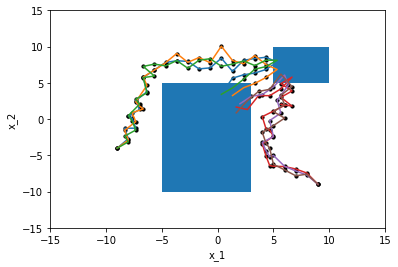

In [8]:
import scipy.linalg as scla
import matplotlib

np.random.seed(4)

time = 50
fig = plt.figure()
ax = fig.add_subplot(111)

Wsqrt = scla.sqrtm(sys_lti.W)
for x0 in (np.array([[-9],[-4]]),np.array([[9],[-9]])):
    for repeating in range(3):
        pol.reset()        
        xx = x0
        
        for t in range(time): 
            # current state
            xt = xx[:,-1].reshape(2,1)
            # next state
            ut = my_policy(xt)
            wt = np.random.normal(0,1,size=(2,1))
            # update state
            xt1 = sys_lti.a.dot(xt)+sys_lti.b.dot(ut) + np.array(Wsqrt).dot(wt)

            xx = np.hstack([xx, xt1])
            if pol.finished() :
                print('reached')
                break
                
        if not pol.finished():
            print('not reached')
        
        # plot trajectory
        plt.plot(xx[0,:],xx[1,:])
        plt.scatter(xx[0,:],xx[1,:], label='Finite states', color='k', s=10, marker="o")

# plot regions
for poly in regions.itervalues():
    V = pc.extreme(poly)
    ax.add_patch(matplotlib.patches.Polygon(V))
    
plt.xlim(np.array([-15,15]))
plt.ylim(np.array([-15,15]))

plt.xlabel('x_1') 
plt.ylabel('x_2') 